In [2]:
# Sources:
#    \item \url{https://www.kaggle.com/tanulsingh077/pytorch-metric-learning-pipeline-only-images}
#    \item \url{https://www.kaggle.com/tanulsingh077/metric-learning-image-tfidf-inference}
#    \item \url{https://www.kaggle.com/underwearfitting/pytorch-densenet-arcface-validation-training}
#    \item \url{https://www.kaggle.com/underwearfitting/pytorch-densenet-arcface-validation-inference}

%load_ext autoreload
%autoreload 2


import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from utils import *
from datasets import *
from models import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
DIM = (256, 256)

NUM_WORKERS = 1
TRAIN_BATCH_SIZE = 24
VALID_BATCH_SIZE = 16
EPOCHS = 30
SEED = 2020
LR = 3e-4

####################################### Scheduler and its params ############################################################
SCHEDULER = 'CosineAnnealingWarmRestarts' #'CosineAnnealingLR'
factor=0.2 # ReduceLROnPlateau
patience=4 # ReduceLROnPlateau
eps=1e-6 # ReduceLROnPlateau
T_max=10 # CosineAnnealingLR
T_0=4 # CosineAnnealingWarmRestarts
min_lr=1e-6

############################################## Model Params ###############################################################
model_params = {
    'n_classes':11014,
    'model_name':'efficientnet_b3',
    'use_fc':False,
    'fc_dim':512,
    'dropout':0.0,
    'loss_module':'arcface',
    's':30.0,
    'margin':0.50,
    'ls_eps':0.0,
    'theta_zero':0.785,
    'pretrained':True
}

# Defining Device
device = torch.device("cuda")

In [8]:
seed_everything(seed=SEED)

# Dataset Creation
data_dir = 'input/shopee-product-matching/train_images'
train_df = pd.read_csv('input/shopee-product-matching/train.csv')

# setup ground truth as list of posting ids similar to submisison.csv
# dictionary that maps sample # to posting_id's that match
tmp = train_df.groupby('label_group').posting_id.agg('unique').to_dict()
train_df['target'] = train_df.label_group.map(tmp)

# add filepath as dataframe member for easy loading
train_df['file_path'] = train_df.image.apply(lambda x: os.path.join(data_dir, x))

# Prep labels to be from 0 to N-1 groups
le = LabelEncoder()
train_df.label_group = le.fit_transform(train_df.label_group)

# Validation set is first 1000 samples
train_df_val = train_df[0:1000]

# training is the rest of the data
train_df = train_df[1000:]

Setting all seeds to be 2020 to reproduce...


In [3]:
def fetch_scheduler(optimizer):
    if SCHEDULER =='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True, eps=eps)
    elif SCHEDULER =='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=min_lr, last_epoch=-1)
    elif SCHEDULER =='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=1, eta_min=min_lr, last_epoch=-1)
    return scheduler

if __name__ == '__main__':

    # Create SHOPEEDataset
    train_dataset = ShopeeDataset(train_df, transforms=get_train_transforms(DIM))
    valid_dataset = ShopeeDataset(train_df_val, transforms=get_valid_transforms(DIM))

    # Dataloaders for torch
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=True,
        pin_memory=True,
        drop_last=True
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=False,
        pin_memory=True,
        drop_last=False,
    )



    torch.cuda.empty_cache()

    # Create model on GPU
    model = ShopeeNet(**model_params)
    model.to(device)

    # Defining criterion
    criterion = nn.CrossEntropyLoss()
    criterion.to(device)

    # Defining Optimizer with weight decay to params other than bias and layer norms
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

    optimizer = torch.optim.Adam(optimizer_parameters, lr=LR)

    # Defining LR SCheduler
    scheduler = fetch_scheduler(optimizer)

    # THE ENGINE LOOP
    best_loss = 10000
    for epoch in range(EPOCHS):

        # train on training set
        train_loss = train_fn(train_loader, model, criterion, optimizer, device, scheduler=scheduler, epoch=epoch)

        # evaluate on validation set
        valid_loss = eval_fn(valid_loader, model, criterion, device)

        if valid_loss.avg < best_loss:

            # save off model if we beat performance
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), f'model_{model_params["model_name"]}_IMG_SIZE_{DIM[0]}_{model.loss_module}.bin')
            print('best model found for epoch {}'.format(epoch))

Building Model Backbone for efficientnet_b0 model


In [47]:
if __name__ == '__main__':

    model_params = {
    'n_classes':11014,
    'model_name':'efficientnet_b3',
    'use_fc':True,
    'fc_dim':512,
    'dropout':0.0,
    'loss_module':'arcface',
    's':30.0,
    'margin':0.50,
    'ls_eps':0.0,
    'theta_zero':0.785,
    'pretrained':False
    }

    # create model and load model weights
    model = ShopeeNet(**model_params)
    model.load_state_dict(torch.load('model_efficientnet_b3_IMG_SIZE_256_arcface.bin'))
    model.to(device)

    valid_dataset = ShopeeDataset(train_df_val, transforms=get_valid_transforms(DIM))
    valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)


    embeddings = []
    model.eval()

    with torch.no_grad():

        # feed in batches of images and get their embeddings
        for batch_idx, (images, labels) in enumerate(valid_loader):
            images = images.to(device)
            embedding_ = model.extract_feat(images)
            embedding_ = F.normalize(embedding_)
            embeddings.append( embedding_.detach().cpu() )


embeddings_mat = torch.cat(embeddings).cpu().numpy()

Building Model Backbone for efficientnet_b3 model


In [33]:
# 50 classes
model_nearest_neighbor = NearestNeighbors(n_neighbors=50)

# cluster them into 50 classes?
model_nearest_neighbor.fit(embeddings_mat)

distances, indices = model_nearest_neighbor.kneighbors(embeddings_mat)

In [46]:
distances[0,:]

array([ 0.      , 18.667265, 18.752857, 18.932419, 18.937754, 18.958773,
       18.977259, 19.05752 , 19.076742, 19.103159, 19.165277, 19.216366,
       19.247007, 19.24743 , 19.27228 , 19.304028, 19.313313, 19.461992,
       19.464455, 19.466194, 19.490717, 19.510717, 19.521349, 19.52709 ,
       19.610464, 19.635408, 19.660368, 19.698343, 19.725807, 19.749786,
       19.772676, 19.77992 , 19.78179 , 19.8088  , 19.828644, 19.861155,
       19.89393 , 19.899506, 19.906227, 19.918905, 19.919172, 19.92144 ,
       19.950922, 19.950922, 19.96246 , 19.96284 , 19.973148, 19.993706,
       19.998423, 20.015663], dtype=float32)

In [ ]:
k = 5
idx = np.where(distances[k,] < threshold)[0]

ids = indices[k, idx]

In [44]:
ids

array([5], dtype=int64)

In [35]:
thresholds = list(np.arange(0, 1, 0.01))

scores = []

# for each threshold
for threshold in [1]:

    predictions = []

    # loop through each sample k
    for k in range(embeddings_mat.shape[0]):

        # indices where distances less than some threshold
        idx = np.where(distances[k,] < threshold)[0]

        # grab posting id's
        ids = indices[k, idx]
        posting_ids = ' '.join(train_df_val['posting_id'].iloc[ids].values)
        predictions.append(posting_ids)


    # list of posting id's (strings) is our prediction
    train_df_val['pred'] = predictions

    # compute f1 scores
    scores, score = row_wise_f1_score(train_df_val.target, train_df_val.pred)

    print(f'Our f1 score for threshold {threshold} is {score}')
    scores.append(score)

Our f1 score for threshold 0.0 is 0.0
Our f1 score for threshold 0.001 is 0.09336841675295768
Our f1 score for threshold 0.002 is 0.09336841675295768
Our f1 score for threshold 0.003 is 0.09336841675295768
Our f1 score for threshold 0.004 is 0.09336841675295768
Our f1 score for threshold 0.005 is 0.09336841675295768
Our f1 score for threshold 0.006 is 0.09336841675295768
Our f1 score for threshold 0.007 is 0.09336841675295768
Our f1 score for threshold 0.008 is 0.09336841675295768
Our f1 score for threshold 0.009000000000000001 is 0.09336841675295768
Our f1 score for threshold 0.01 is 0.09336841675295768
Our f1 score for threshold 0.011 is 0.09336841675295768
Our f1 score for threshold 0.012 is 0.09336841675295768
Our f1 score for threshold 0.013000000000000001 is 0.09336841675295768
Our f1 score for threshold 0.014 is 0.09336841675295768
Our f1 score for threshold 0.015 is 0.09336841675295768
Our f1 score for threshold 0.016 is 0.09336841675295768
Our f1 score for threshold 0.017 is 0

In [75]:
# number of unique classes
train_df.label_group.nunique()


11008

In [82]:
image_sizes = set()

for i in range(33250):
    path = train_df.file_path.iloc[i]
    img = cv2.imread(path)
    dims = img.shape
    image_sizes.add(dims)

In [92]:
train_df['textln'] = train_df.apply(lambda x: len(x['title']), axis=1)

len(image_sizes)

818

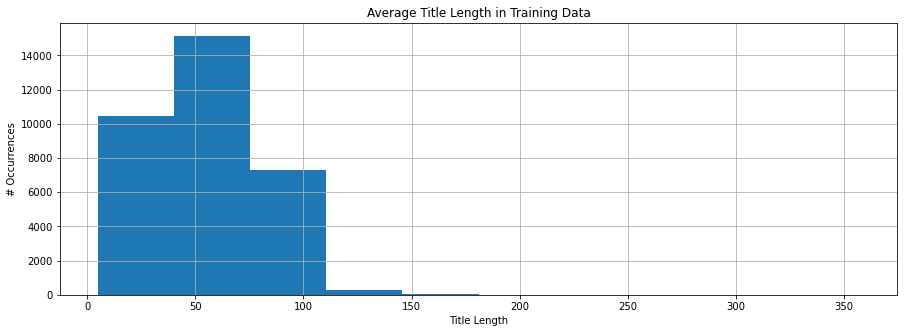

In [97]:
import matplotlib.pyplot as plt

plt.hist(train_df['textln'])
plt.xlabel('Title Length')
plt.ylabel('# Occurrences')
plt.title('Average Title Length in Training Data')
plt.grid()
plt.savefig('avgtitle_len.png')

ModuleNotFoundError: No module named 'torchsummary'

In [111]:
from torchsummary import summary
model = ShopeeNet(model_params['n_classes']).cuda()
#summary(cnn, (1, 28, 28))
summary(model,(1,256,256),1)

Building Model Backbone for efficientnet_b0 model


TypeError: forward() missing 1 required positional argument: 'label'

In [ ]:
train_df['textln'].min()
#train_df['textln'].max()

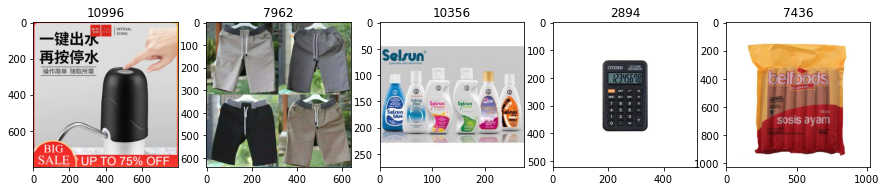

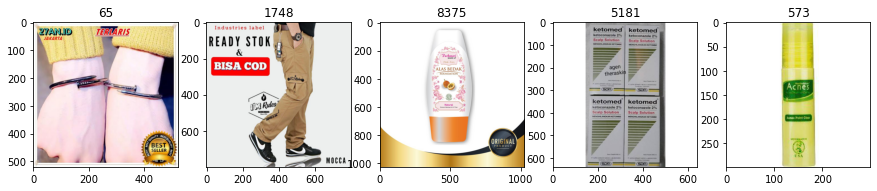

In [90]:
from pylab import rcParams
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 15,5
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):

        idx = i*5 + p

        path = train_df.file_path.iloc[idx]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = train_df.label_group.iloc[idx]
        axarr[p].imshow(img)
        axarr[p].set_title(label.item())

In [88]:
plt.savefig('sampletraining.png')

<Figure size 1080x360 with 0 Axes>

In [125]:
train_df[['posting_id','label_group','target']].iloc[0:10]


,posting_id,label_group,target
1000,train_168752812,10996,"[train_168752812, train_3295799432]"
1001,train_4016842252,7962,"[train_4016842252, train_1090536099, train_163..."
1002,train_81918230,10356,"[train_81918230, train_2519330360]"
1003,train_1872355551,2894,"[train_1872355551, train_2260111278]"
1004,train_485217958,7436,"[train_485217958, train_4242429003]"
1005,train_3078701030,65,"[train_3078701030, train_127937257]"
1006,train_1536582395,1748,"[train_1536582395, train_1696208176]"
1007,train_951434350,8375,"[train_951434350, train_3738814377]"
1008,train_2664129645,5181,"[train_2664129645, train_649619183, train_4983..."
1009,train_164017356,573,"[train_164017356, train_1522799956]"


In [128]:
model2 = SHOPEEDenseNet(256, train_df.label_group.nunique())
pytorch_total_params2 = sum(p.numel() for p in model2.parameters())
print(pytorch_total_params2)

77908584


In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())

In [127]:
pytorch_total_params

18116482

In [ ]:
print(train_df_val['pred'].iloc[0])

In [ ]:
thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})
max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
best_threshold = max_score['thresholds'].values[0]
best_score = max_score['scores'].values[0]
print(f'Our best score is {best_score} and has a threshold {best_threshold}')

# Use threshold
predictions = []
for k in range(embeddings.shape[0]):
    # Because we are predicting the test set that have 70K images and different label groups, confidence should be smaller
    if image:
        idx = np.where(distances[k,] < 2.7)[0]
    else:
        idx = np.where(distances[k,] < 0.60)[0]
    ids = indices[k, idx]
    posting_ids = df['posting_id'].iloc[ids].values
    predictions.append(posting_ids)



In [48]:
embeddings_mat.shape[0]


1000

In [65]:

sim_thresh = 0.5

# dot product with each other, only grab if above similarity threshold
# since model output is normalize this is equivalent to cosine similarity
selection = ((embeddings_mat @ embeddings_mat.T) > sim_thresh)

In [50]:
# take target (list of strings) and collapse to string separated by spaces
train_df_val['target_string'] = train_df_val.apply(lambda x: target_string(x['target']),axis=1)
train_df_val.head(5)

,posting_id,image,image_phash,title,label_group,target,file_path,pred,target_string
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,"[train_129225211, train_2278313361]",input/shopee-product-matching/train_images\000...,train_129225211,train_129225211 train_2278313361
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,"[train_3386243561, train_3423213080]",input/shopee-product-matching/train_images\000...,train_3386243561,train_3386243561 train_3423213080
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,6172,"[train_2288590299, train_3803689425]",input/shopee-product-matching/train_images\000...,train_2288590299,train_2288590299 train_3803689425
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,10509,"[train_2406599165, train_3342059966]",input/shopee-product-matching/train_images\001...,train_2406599165,train_2406599165 train_3342059966
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,9425,"[train_3369186413, train_921438619]",input/shopee-product-matching/train_images\001...,train_3369186413,train_3369186413 train_921438619


In [71]:
selection

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [66]:
matches = []

# loop through each row (each sample)
for row in selection:

    # grab the samples that meet the threshold criteria, grab posting id and convert to list of strings
    posting_ids_that_match = train_df_val.iloc[row].posting_id.tolist()

    # collapse to one long string and add to list
    matches.append(posting_ids_that_match)


tmp = dict( zip(range(len(matches)), matches) )
train_df_val['pred'] = train_df_val.index.map(tmp)

In [67]:
# convert list of strings for target into one long string
train_df_val['target_string'] = train_df_val.apply(lambda x: target_string(x['target']), axis=1)

# do the same for prediction
train_df_val['pred_string'] = train_df_val.apply(lambda x: target_string(x['pred']), axis=1)

In [68]:
# boolean for each target/pred pair if the strings match exactly
train_df_val['prediction_accuracy'] = train_df_val.apply(lambda x: match(x['target_string'], x['pred_string']),axis=1)
prediction_accuracy_v1 = train_df_val.groupby(['prediction_accuracy'])['posting_id'].count()

ans = prediction_accuracy_v1[True] / (prediction_accuracy_v1[True] + prediction_accuracy_v1[False])

ans*100

#Accuracy
#print("Accuracy of V3" , (prediction_accuracy_v1[True]/(prediction_accuracy_v1[True] + prediction_accuracy_v1[False]))*100)

0.6

In [73]:

idx = 12
print(train_df_val.target.iloc[idx])
print(train_df_val.pred.iloc[idx])


['train_2496690777' 'train_2771755203' 'train_1638187876']
['train_2496690777', 'train_2771755203']


In [69]:
scores, score = row_wise_f1_score(train_df_val.target, train_df_val.pred)

print(score)

0.5028750400666645


In [116]:
from pylab import rcParams
import matplotlib.pyplot as plt


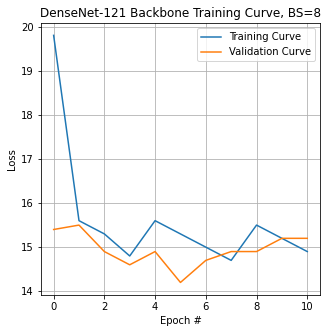

In [119]:
epoch = range(0,11)
train_losses = [19.8, 15.6, 15.3, 14.8, 15.6, 15.3, 15, 14.7, 15.5, 15.2, 14.9]
eval_losses = [15.4, 15.5, 14.9, 14.6, 14.9, 14.2, 14.7, 14.9, 14.9, 15.2, 15.2]

rcParams['figure.figsize'] = 5,5
plt.plot(epoch, train_losses)
plt.plot(epoch, eval_losses)
plt.grid()
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('DenseNet-121 Backbone Training Curve, BS=8')
plt.legend(['Training Curve', 'Validation Curve'])
plt.savefig('training_curve_densenet.png')
# '''
# Building Model Backbone for efficientnet_b3 model
# 100%|██████████| 4156/4156 [12:40<00:00,  5.46it/s, Epoch=0, LR=0.0003, Train_Loss=19.8]
# 100%|██████████| 63/63 [00:05<00:00, 11.22it/s, Eval_Loss=15.4]
# best model found for epoch 0
# 100%|██████████| 4156/4156 [12:31<00:00,  5.53it/s, Epoch=1, LR=0.000256, Train_Loss=15.6]
# 100%|██████████| 63/63 [00:05<00:00, 11.20it/s, Eval_Loss=15.5]
# 100%|██████████| 4156/4156 [12:39<00:00,  5.47it/s, Epoch=2, LR=0.00015, Train_Loss=15.3]
# 100%|██████████| 63/63 [00:05<00:00, 11.17it/s, Eval_Loss=14.9]
# best model found for epoch 2
# 100%|██████████| 4156/4156 [12:24<00:00,  5.58it/s, Epoch=3, LR=4.48e-5, Train_Loss=14.8]
# 100%|██████████| 63/63 [00:05<00:00, 11.32it/s, Eval_Loss=14.6]
# best model found for epoch 3
# 100%|██████████| 4156/4156 [12:38<00:00,  5.48it/s, Epoch=4, LR=0.0003, Train_Loss=15.6]
# 100%|██████████| 63/63 [00:05<00:00, 10.98it/s, Eval_Loss=14.9]
# 100%|██████████| 4156/4156 [12:48<00:00,  5.41it/s, Epoch=5, LR=0.000256, Train_Loss=15.3]
# 100%|██████████| 63/63 [00:05<00:00, 11.04it/s, Eval_Loss=14.2]
# best model found for epoch 5
# 100%|██████████| 4156/4156 [12:52<00:00,  5.38it/s, Epoch=6, LR=0.00015, Train_Loss=15]
# 100%|██████████| 63/63 [00:05<00:00, 10.98it/s, Eval_Loss=14.7]
# 100%|██████████| 4156/4156 [13:11<00:00,  5.25it/s, Epoch=7, LR=4.48e-5, Train_Loss=14.7]
# 100%|██████████| 63/63 [00:05<00:00, 10.64it/s, Eval_Loss=14.9]
# 100%|██████████| 4156/4156 [13:21<00:00,  5.19it/s, Epoch=8, LR=0.0003, Train_Loss=15.5]
# 100%|██████████| 63/63 [00:05<00:00, 10.61it/s, Eval_Loss=14.9]
# 100%|██████████| 4156/4156 [13:18<00:00,  5.20it/s, Epoch=9, LR=0.000256, Train_Loss=15.2]
# 100%|██████████| 63/63 [00:05<00:00, 10.58it/s, Eval_Loss=15.2]
# 100%|██████████| 4156/4156 [13:00<00:00,  5.32it/s, Epoch=10, LR=0.00015, Train_Loss=14.9]
# 100%|██████████| 63/63 [00:05<00:00, 10.56it/s, Eval_Loss=15.2]
#
# '''

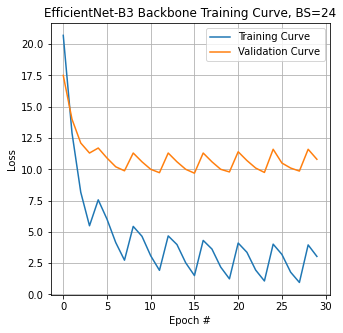

In [120]:
rcParams['figure.figsize'] = 5,5
epoch = range(0,30)
train_losses = [20.7, 12.9, 8.17, 5.49, 7.56, 6.02, 4.15,
                2.74, 5.44, 4.65, 3.09, 1.93, 4.68, 3.99,
                2.53, 1.51, 4.32, 3.63, 2.19, 1.25, 4.11,
                3.37, 1.95, 1.08, 4.02, 3.2, 1.78, 0.962,
                3.96, 3.04]

eval_losses = [17.5, 14, 12.1, 11.3, 11.7, 10.9, 10.2, 9.88,
               11.3, 10.6, 10.0, 9.73, 11.3, 10.6, 10, 9.69,
               11.3, 10.6, 10.0, 9.79, 11.4, 10.7, 10.1, 9.75,
               11.6, 10.5, 10.1, 9.86, 11.6, 10.8]

plt.plot(epoch, train_losses)
plt.plot(epoch, eval_losses)
plt.grid()
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('EfficientNet-B3 Backbone Training Curve, BS=24')
plt.legend(['Training Curve', 'Validation Curve'])
plt.savefig('training_curve_efficientnet.png')
# '''
# Building Model Backbone for efficientnet_b3 model
# 100%|██████████| 1385/1385 [05:28<00:00,  4.21it/s, Epoch=0, LR=0.0003, Train_Loss=20.7]
# 100%|██████████| 63/63 [00:07<00:00,  8.90it/s, Eval_Loss=17.5]
# best model found for epoch 0
# 100%|██████████| 1385/1385 [05:28<00:00,  4.21it/s, Epoch=1, LR=0.000256, Train_Loss=12.9]
# 100%|██████████| 63/63 [00:07<00:00,  8.79it/s, Eval_Loss=14]
# best model found for epoch 1
# 100%|██████████| 1385/1385 [05:28<00:00,  4.21it/s, Epoch=2, LR=0.00015, Train_Loss=8.17]
# 100%|██████████| 63/63 [00:07<00:00,  8.76it/s, Eval_Loss=12.1]
# best model found for epoch 2
# 100%|██████████| 1385/1385 [05:31<00:00,  4.18it/s, Epoch=3, LR=4.48e-5, Train_Loss=5.49]
# 100%|██████████| 63/63 [00:07<00:00,  8.68it/s, Eval_Loss=11.3]
# best model found for epoch 3
# 100%|██████████| 1385/1385 [05:26<00:00,  4.24it/s, Epoch=4, LR=0.0003, Train_Loss=7.56]
# 100%|██████████| 63/63 [00:07<00:00,  8.88it/s, Eval_Loss=11.7]
# 100%|██████████| 1385/1385 [05:21<00:00,  4.31it/s, Epoch=5, LR=0.000256, Train_Loss=6.02]
# 100%|██████████| 63/63 [00:07<00:00,  8.96it/s, Eval_Loss=10.9]
# best model found for epoch 5
# 100%|██████████| 1385/1385 [05:27<00:00,  4.23it/s, Epoch=6, LR=0.00015, Train_Loss=4.15]
# 100%|██████████| 63/63 [00:06<00:00,  9.01it/s, Eval_Loss=10.2]
# best model found for epoch 6
# 100%|██████████| 1385/1385 [05:21<00:00,  4.30it/s, Epoch=7, LR=4.48e-5, Train_Loss=2.74]
# 100%|██████████| 63/63 [00:07<00:00,  8.89it/s, Eval_Loss=9.88]
# best model found for epoch 7
# 100%|██████████| 1385/1385 [05:21<00:00,  4.31it/s, Epoch=8, LR=0.0003, Train_Loss=5.44]
# 100%|██████████| 63/63 [00:07<00:00,  8.92it/s, Eval_Loss=11.3]
# 100%|██████████| 1385/1385 [05:45<00:00,  4.01it/s, Epoch=9, LR=0.000256, Train_Loss=4.65]
# 100%|██████████| 63/63 [00:07<00:00,  8.75it/s, Eval_Loss=10.6]
# 100%|██████████| 1385/1385 [05:50<00:00,  3.95it/s, Epoch=10, LR=0.00015, Train_Loss=3.09]
# 100%|██████████| 63/63 [00:07<00:00,  8.87it/s, Eval_Loss=10]
# 100%|██████████| 1385/1385 [05:35<00:00,  4.13it/s, Epoch=11, LR=4.48e-5, Train_Loss=1.93]
# 100%|██████████| 63/63 [00:07<00:00,  8.98it/s, Eval_Loss=9.73]
# best model found for epoch 11
# 100%|██████████| 1385/1385 [05:22<00:00,  4.29it/s, Epoch=12, LR=0.0003, Train_Loss=4.68]
# 100%|██████████| 63/63 [00:07<00:00,  8.86it/s, Eval_Loss=11.3]
# 100%|██████████| 1385/1385 [05:29<00:00,  4.21it/s, Epoch=13, LR=0.000256, Train_Loss=3.99]
# 100%|██████████| 63/63 [00:07<00:00,  8.86it/s, Eval_Loss=10.6]
# 100%|██████████| 1385/1385 [05:33<00:00,  4.15it/s, Epoch=14, LR=0.00015, Train_Loss=2.53]
# 100%|██████████| 63/63 [00:07<00:00,  8.87it/s, Eval_Loss=10]
# 100%|██████████| 1385/1385 [05:44<00:00,  4.02it/s, Epoch=15, LR=4.48e-5, Train_Loss=1.51]
# 100%|██████████| 63/63 [00:07<00:00,  8.59it/s, Eval_Loss=9.69]
# best model found for epoch 15
# 100%|██████████| 1385/1385 [05:31<00:00,  4.18it/s, Epoch=16, LR=0.0003, Train_Loss=4.32]
# 100%|██████████| 63/63 [00:07<00:00,  8.26it/s, Eval_Loss=11.3]
# 100%|██████████| 1385/1385 [05:35<00:00,  4.13it/s, Epoch=17, LR=0.000256, Train_Loss=3.63]
# 100%|██████████| 63/63 [00:07<00:00,  8.51it/s, Eval_Loss=10.6]
# 100%|██████████| 1385/1385 [05:26<00:00,  4.24it/s, Epoch=18, LR=0.00015, Train_Loss=2.19]
# 100%|██████████| 63/63 [00:07<00:00,  8.57it/s, Eval_Loss=10]
# 100%|██████████| 1385/1385 [05:43<00:00,  4.03it/s, Epoch=19, LR=4.48e-5, Train_Loss=1.25]
# 100%|██████████| 63/63 [00:07<00:00,  8.74it/s, Eval_Loss=9.79]
# 100%|██████████| 1385/1385 [05:21<00:00,  4.31it/s, Epoch=20, LR=0.0003, Train_Loss=4.11]
# 100%|██████████| 63/63 [00:07<00:00,  8.49it/s, Eval_Loss=11.4]
# 100%|██████████| 1385/1385 [05:24<00:00,  4.27it/s, Epoch=21, LR=0.000256, Train_Loss=3.37]
# 100%|██████████| 63/63 [00:07<00:00,  8.56it/s, Eval_Loss=10.7]
# 100%|██████████| 1385/1385 [05:25<00:00,  4.25it/s, Epoch=22, LR=0.00015, Train_Loss=1.95]
# 100%|██████████| 63/63 [00:07<00:00,  8.52it/s, Eval_Loss=10.1]
# 100%|██████████| 1385/1385 [05:27<00:00,  4.23it/s, Epoch=23, LR=4.48e-5, Train_Loss=1.08]
# 100%|██████████| 63/63 [00:07<00:00,  8.65it/s, Eval_Loss=9.75]
# 100%|██████████| 1385/1385 [05:25<00:00,  4.25it/s, Epoch=24, LR=0.0003, Train_Loss=4.02]
# 100%|██████████| 63/63 [00:07<00:00,  8.82it/s, Eval_Loss=11.6]
# 100%|██████████| 1385/1385 [05:27<00:00,  4.23it/s, Epoch=25, LR=0.000256, Train_Loss=3.2]
# 100%|██████████| 63/63 [00:07<00:00,  8.63it/s, Eval_Loss=10.5]
# 100%|██████████| 1385/1385 [05:27<00:00,  4.23it/s, Epoch=26, LR=0.00015, Train_Loss=1.78]
# 100%|██████████| 63/63 [00:07<00:00,  8.58it/s, Eval_Loss=10.1]
# 100%|██████████| 1385/1385 [05:24<00:00,  4.26it/s, Epoch=27, LR=4.48e-5, Train_Loss=0.962]
# 100%|██████████| 63/63 [00:07<00:00,  9.00it/s, Eval_Loss=9.86]
# 100%|██████████| 1385/1385 [05:23<00:00,  4.28it/s, Epoch=28, LR=0.0003, Train_Loss=3.96]
# 100%|██████████| 63/63 [00:07<00:00,  8.93it/s, Eval_Loss=11.6]
# 100%|██████████| 1385/1385 [05:21<00:00,  4.30it/s, Epoch=29, LR=0.000256, Train_Loss=3.04]
# 100%|██████████| 63/63 [00:06<00:00,  9.04it/s, Eval_Loss=10.8]
#
# Process finished with exit code 0
#
# '''